In [1]:
!pip install numpy pandas matplotlib deap

In [2]:
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms

In [3]:
def solve_knapsack_dp(weights, values, capacity):
    """DP solution for 0/1 knapsack."""
    start = time.time()
    n = len(weights)
    dp = [[0]*(capacity+1) for _ in range(n+1)]
    for i in range(1, n+1):
        for w in range(1, capacity+1):
            if weights[i-1] <= w:
                dp[i][w] = max(values[i-1] + dp[i-1][w-weights[i-1]],
                               dp[i-1][w])
            else:
                dp[i][w] = dp[i-1][w]
    # backtrack
    res, w = [], capacity
    for i in range(n, 0, -1):
        if dp[i][w] != dp[i-1][w]:
            res.append(i-1)
            w -= weights[i-1]
    res.reverse()
    return dp[n][capacity], res, time.time()-start

def solve_knapsack_ga(weights, values, capacity,
                      pop_size=100, max_gen=100,
                      cx_prob=0.7, mut_prob=0.2):
    """GA solution for 0/1 knapsack via DEAP."""
    start = time.time()
    # create types
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)
    toolbox = base.Toolbox()
    toolbox.register("attr_bool", random.randint, 0, 1)
    toolbox.register("individual", tools.initRepeat,
                     creator.Individual, toolbox.attr_bool, len(weights))
    toolbox.register("population", tools.initRepeat, list,
                     toolbox.individual)
    # fitness
    def eval_knap(ind):
        tv, tw = 0, 0
        for i, bit in enumerate(ind):
            if bit:
                tv += values[i]; tw += weights[i]
        return (tv,) if tw <= capacity else (0,)
    toolbox.register("evaluate", eval_knap)
    toolbox.register("mate",    tools.cxTwoPoint)
    toolbox.register("mutate",  tools.mutFlipBit, indpb=0.05)
    toolbox.register("select",  tools.selTournament, tournsize=3)
    # evolve
    pop = toolbox.population(n=pop_size)
    hof = tools.HallOfFame(1)
    algorithms.eaSimple(pop, toolbox,
                        cxpb=cx_prob, mutpb=mut_prob,
                        ngen=max_gen,
                        halloffame=hof,
                        verbose=False)
    best = hof[0]
    sel = [i for i,b in enumerate(best) if b]
    total = sum(values[i] for i in sel)
    # clean up for re-use
    del creator.FitnessMax, creator.Individual
    return total, sel, time.time()-start

def generate_knapsack_instance(n,
                               max_weight=100,
                               max_value=100,
                               capacity_ratio=0.5):
    """Random weights/values + capacity = ratio * sum(weights)."""
    w = [random.randint(1, max_weight) for _ in range(n)]
    v = [random.randint(1, max_value)  for _ in range(n)]
    cap = int(sum(w)*capacity_ratio)
    return w, v, cap

In [4]:
def run_comparative_experiment(sizes, trials=3, capacity_ratio=0.5,
                               ga_pop_size=100, ga_max_gen=100,
                               dp_timeout=300):
    rec = []
    for n in sizes:
        for t in range(trials):
            w,v,cap = generate_knapsack_instance(n, capacity_ratio=capacity_ratio)
            # DP (skip if too big)
            dp_val = dp_items = dp_time = None
            dp_error = True
            if n <= 1000:
                try:
                    dp_val, dp_items, dp_time = solve_knapsack_dp(w, v, cap)
                    dp_error = False
                except Exception:
                    pass
            # GA
            ga_val, ga_items, ga_time = solve_knapsack_ga(
                w, v, cap,
                pop_size=ga_pop_size, max_gen=ga_max_gen)
            err = None
            if not dp_error and dp_val>0:
                err = 100*(1 - ga_val/dp_val)
            rec.append({
                'n': n, 'trial': t+1, 'capacity':cap,
                'dp_val':dp_val, 'dp_time':dp_time,
                'ga_val':ga_val, 'ga_time':ga_time,
                'error_%':err, 'dp_error':dp_error
            })
    return pd.DataFrame(rec)

def plot_results(df):
    grp = df.groupby('n').agg({
        'dp_time':['mean','std'],
        'ga_time':['mean','std'],
        'error_%':['mean','std']
    }).reset_index()
    grp.columns = ['_'.join(c).strip('_') for c in grp.columns]
    # runtime plot
    plt.figure(figsize=(8,5))
    plt.errorbar(grp['n'], grp['dp_time_mean'], yerr=grp['dp_time_std'], fmt='o-', label='DP')
    plt.errorbar(grp['n'], grp['ga_time_mean'], yerr=grp['ga_time_std'], fmt='s-', label='GA')
    plt.xlabel('Number of items'); plt.ylabel('Time (s)')
    plt.title('DP vs GA Runtime'); plt.legend(); plt.grid(True)
    plt.show()
    # error plot
    valid = grp[~grp['error_%_mean'].isna()]
    if not valid.empty:
        plt.figure(figsize=(8,5))
        plt.errorbar(valid['n'], valid['error_%_mean'],
                     yerr=valid['error_%_std'], fmt='o-')
        plt.xlabel('Number of items')
        plt.ylabel('Error (%) below optimal')
        plt.title('GA Solution Quality')
        plt.grid(True); plt.show()

,n,trial,capacity,dp_val,dp_time,ga_val,ga_time,error_%,dp_error
0,10,1,356,422,0.000710,422,0.149983,0.000000,False
1,10,2,280,347,0.001000,347,0.137041,0.000000,False
2,25,1,696,897,0.003999,897,0.193830,0.000000,False
3,25,2,507,846,0.003064,844,0.182600,0.236407,False
4,50,1,1365,1957,0.017020,1907,0.270895,2.554931,False


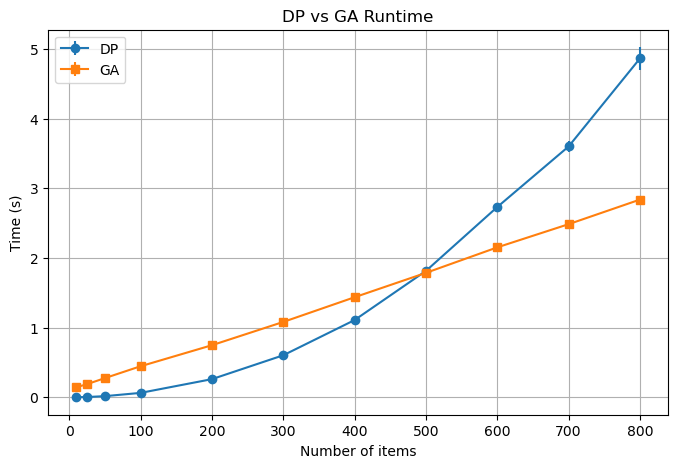

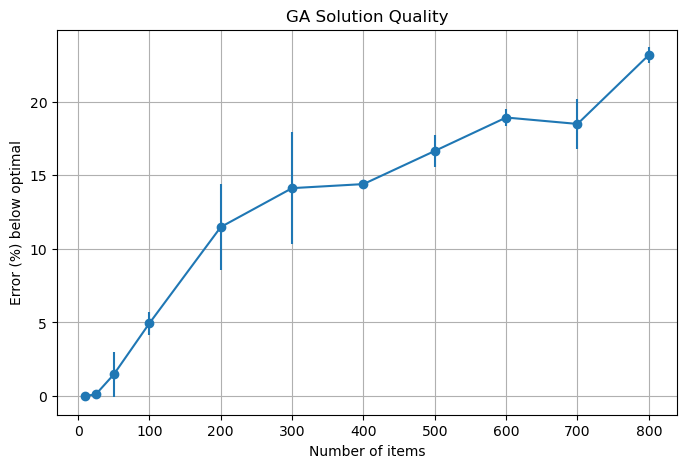

In [13]:
if __name__ == '__main__':
    sizes = [10, 25, 50, 100, 200, 300, 400, 500, 600, 700, 800]
    df = run_comparative_experiment(sizes, trials=2)
    display(df.head())
    plot_results(df)